<a href="https://colab.research.google.com/github/buihanhtrang/Ultrasound_Img_Segmentation_Unet/blob/main/paper_code1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Automated characterisation of ultrasound images of ovarian tumours: the diagnostic accuracy of a support vector machine and image processing with a local binary pattern operator

implement libraries

In [ ]:
#!pip install tensorflow

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import cv2
import skimage as ski
import os, sys
import matplotlib.pylab as plt

from tqdm import tqdm
from PIL import Image
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from skimage import feature
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from skimage.feature import local_binary_pattern # pip install scikit-image
#from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

dataloading

In [ ]:
# Upload from google drive
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Colab Notebooks/UTBT"
os.chdir(path)
!ls

Mounted at /content/gdrive
BVPSTW.zip	   OSF_new  OTU_2d.zip	       U-Net.ipynb
inceptionv3.ipynb  OTU2d    paper_code1.ipynb  USOVA2D.zip


In [ ]:
# Specify the path to your data folder in Google Drive
dir_path = '/content/gdrive/MyDrive/Colab Notebooks/UTBT/OSF_new/'
# Check the contents of the folder
os.listdir(dir_path)

['Mali', 'Benign']

In [ ]:
def load_images(path, num_images=50):

    images = []
    filenames = os.listdir(path)

    # Select a random subset of num_images from the list of filenames
    selected_filenames = np.random.choice(filenames, size=num_images, replace=False)

    for filename in tqdm(selected_filenames):
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images)

In [ ]:
classnames = ['Benign', 'Mali']
num_images_to_load = 50

class_0 = load_images(dir_path + classnames[0], num_images=num_images_to_load)
class_1 = load_images(dir_path + classnames[1], num_images=num_images_to_load)
classes = [class_0, class_1]

for class_images in classes:
    print(class_images.shape)

100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


(50, 425, 465, 3)
(50, 425, 465, 3)


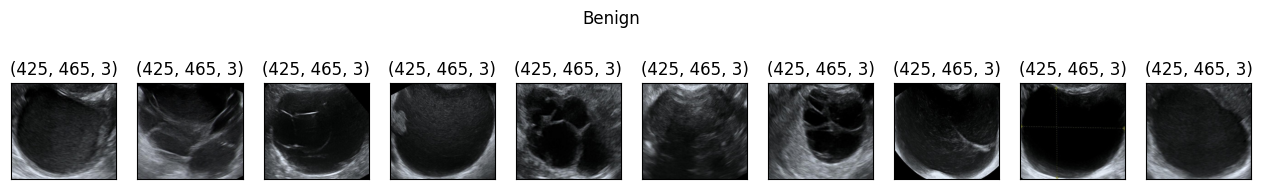

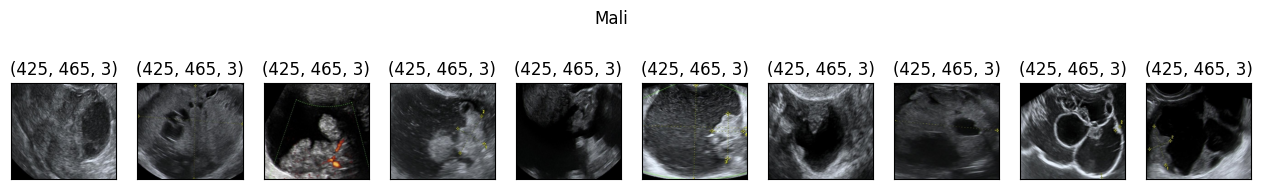

In [ ]:
def show_raw_images(images, classname, start_index=0):
    fig, axes = plt.subplots(ncols=10, nrows=1, figsize=(16, 2.5))
    plt.suptitle(classname)

    index = start_index
    for i in range(10):
        axes[i].imshow(images[index])
        axes[i].set_title(images[index].shape)
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        index += 1
    plt.show()

show_raw_images(class_0, classnames[0], start_index=20)
show_raw_images(class_1, classnames[1])

In [ ]:
# benign_folder = os.path.join(dir_path, 'Benign')
# benign_images = []

# for filename in os.listdir(benign_folder):
#     img_path1 = os.path.join(benign_folder, filename)
#     img1 = load_img(img_path1, target_size=(256, 256))  # Adjust target_size as needed
#
#     benign_images.append(img_array1)

# benign_images = np.array(benign_images)

In [ ]:
# mali_folder = os.path.join(dir_path, 'Mali')
# mali_images = []

# for filename in os.listdir(mali_folder):
#     img_path2 = os.path.join(mali_folder, filename)
#     img2 = load_img(img_path2, target_size=(256, 256))  # Adjust target_size as needed
#     img_array2 = img_to_array(img2) / 255.0  # Normalize pixel values
#     mali_images.append(img_array2)

# mali_images = np.array(mali_images)

##a) Pre-processing

De-noising with Non-local means filter

Text(0.5, 1.0, 'Fourth')

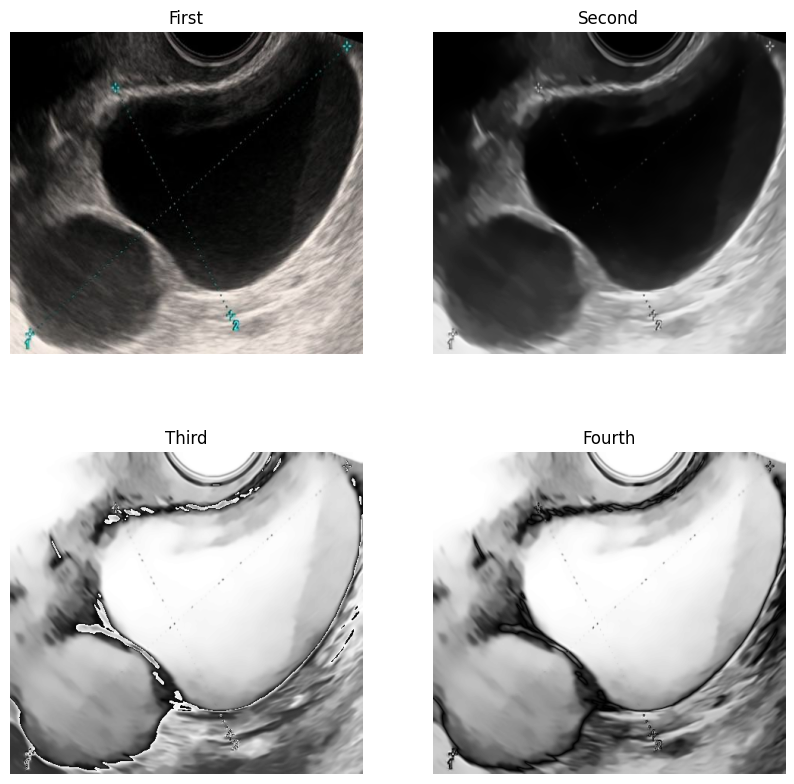

In [ ]:
# Read the noisy image
noisy_image = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/UTBT/OSF_new/Benign/b100.jpg')

# Convert the image to grayscale if it's a color image
gray_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)

# Apply non-local means denoising
denoised_image = cv2.fastNlMeansDenoising(gray_image, None, h=10, templateWindowSize=7, searchWindowSize=20)

#Negative transformation
gray_negative = abs(255-denoised_image)

#Absolute Difference
final_img = abs(255 - 2*denoised_image)
#Absolute Difference with CV
abs_diff = cv2.absdiff(denoised_image, gray_negative)

#Show image
fig = plt.figure(figsize=(10, 10))
# Adds a subplot at the 1st position
fig.add_subplot(2, 2, 1)
# showing image
plt.imshow(noisy_image)
plt.axis('off')
plt.title("First")

# Adds a subplot at the 2nd position
fig.add_subplot(2, 2, 2)

# showing image
plt.imshow(denoised_image, cmap = 'gray')
plt.axis('off')
plt.title("Second")

# Adds a subplot at the 3rd position
fig.add_subplot(2, 2, 3)

# showing image
plt.imshow(final_img, cmap = 'gray')
plt.axis('off')
plt.title("Third")

# Adds a subplot at the 4th position
fig.add_subplot(2, 2, 4)

# showing image
plt.imshow(abs_diff, cmap = 'gray')
plt.axis('off')
plt.title("Fourth")

In [ ]:
def enhanced(images):
    enhanced_img = []
    for image in tqdm(images):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=20)

        #Negative transformation
        gray_neg = abs(255-image)
        #Absolute Difference with CV
        abs_img = cv2.absdiff(image, gray_neg)
        enhanced_img.append(abs_img)

    return np.array(enhanced_img)

class_0_enhanced = enhanced(class_0)
class_1_enhanced = enhanced(class_1)

100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


##b) Local Binary Pattern Histogram (LBPH)

In [ ]:
def get_pixel(img, center, x, y):

    new_value = 0

    try:
        # If local neighbourhood pixel
        # value is greater than or equal
        # to center pixel values then
        # set it to 1
        if img[x][y] >= center:
            new_value = 1

    except:
        # Exception is required when
        # neighbourhood value of a center
        # pixel value is null i.e. values
        # present at boundaries.
        pass

    return new_value

In [ ]:
# Function for calculating LBP
def lbp_calculated_pixel(img, x, y):

    center = img[x][y]

    val_ar = []

    # top_left
    val_ar.append(get_pixel(img, center, x-1, y-1))

    # top
    val_ar.append(get_pixel(img, center, x-1, y))

    # top_right
    val_ar.append(get_pixel(img, center, x-1, y + 1))

    # right
    val_ar.append(get_pixel(img, center, x, y + 1))

    # bottom_right
    val_ar.append(get_pixel(img, center, x + 1, y + 1))

    # bottom
    val_ar.append(get_pixel(img, center, x + 1, y))

    # bottom_left
    val_ar.append(get_pixel(img, center, x + 1, y-1))

    # left
    val_ar.append(get_pixel(img, center, x, y-1))

    # Now, we need to convert binary
    # values to decimal
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]

    val = 0

    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]

    return val

Text(0.5, 1.0, 'LBP Image')

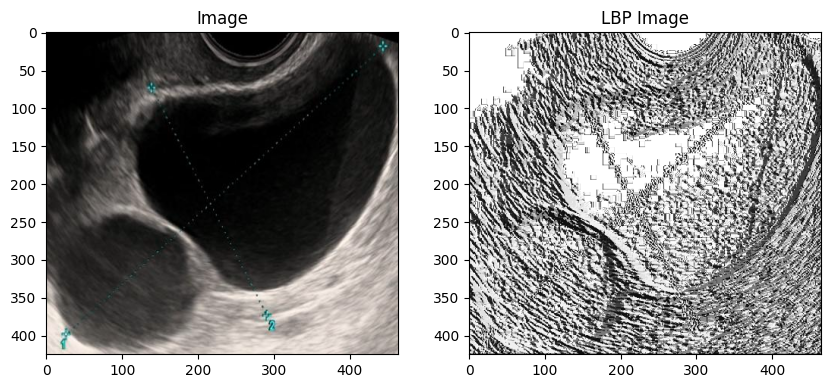

In [ ]:
height1, width1 = gray_image.shape

# Create a numpy array as the same height and width of image
img_lbp = np.zeros((height1, width1), np.uint8)

for i in range(0, height1):
    for j in range(0, width1):
        img_lbp[i, j] = lbp_calculated_pixel(gray_image, i, j)

#Show image
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(noisy_image)
arr[0].set_title('Image')
arr[1].imshow(img_lbp, cmap ="gray")
arr[1].set_title('LBP Image')

Text(0.5, 1.0, 'LBP Image')

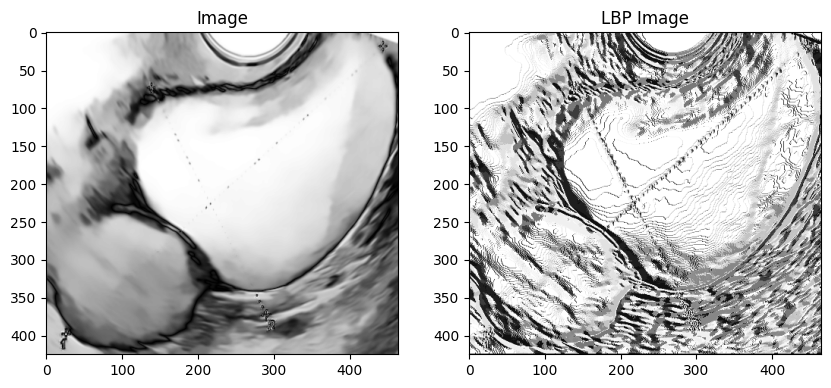

In [ ]:
height2, width2 = abs_diff.shape

# Create a numpy array as the same height and width of image
img_lbp2 = np.zeros((height2, width2), np.uint8)

for i in range(0, height2):
    for j in range(0, width2):
        img_lbp2[i, j] = lbp_calculated_pixel(abs_diff, i, j)

#Show image
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(abs_diff, cmap ="gray")
arr[0].set_title('Image')
arr[1].imshow(img_lbp2, cmap ="gray")
arr[1].set_title('LBP Image')

In [ ]:
# class LocalBinaryPatterns:
# 	def __init__(self, numPoints, radius):
# 		# store the number of points and radius
# 		self.numPoints = numPoints
# 		self.radius = radius
# 	def describe(self, image, eps=1e-7):
# 		# compute the Local Binary Pattern representation
# 		# of the image, and then use the LBP representation
# 		# to build the histogram of patterns
# 		lbp = feature.local_binary_pattern(image, self.numPoints,
# 			self.radius, method="uniform")
# 		(hist, _) = np.histogram(lbp.ravel(),
# 			bins=np.arange(0, self.numPoints + 3),
# 			range=(0, self.numPoints + 2))
# 		# normalize the histogram
# 		hist = hist.astype("float")
# 		hist /= (hist.sum() + eps)
# 		# return the histogram of Local Binary Patterns
# 		return hist

In [ ]:
def extract_lbp(images):
    lbps = []
    for image in tqdm(images):
        lbp = local_binary_pattern(image, P=8, R=2) #Using (8,2) LBP
        lbps.append(lbp)

    return np.array(lbps)

##c) Segmentation

Run U-net

Labeling

In [ ]:
no_of_samples = 50
labels = np.array([0]*no_of_samples + [1]*no_of_samples) #O for Benign and 1 for Mali
labels[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Put all the preprocessing image into all_image



In [ ]:
all_images = np.vstack((class_0_enhanced, class_1_enhanced))
all_images.shape

(100, 425, 465)

Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_images,
                                                    labels,
                                                    test_size=0.2)

print('X_train.shape\t', X_train.shape)
print('X_test.shape\t', X_test.shape)
print('y_train.shape\t', y_train.shape)
print('y_test.shape\t', y_test.shape)

X_train.shape	 (80, 425, 465)
X_test.shape	 (20, 425, 465)
y_train.shape	 (80,)
y_test.shape	 (20,)


In [ ]:
X_train_lbp = extract_lbp(X_train)
X_test_lbp = extract_lbp(X_test)

100%|██████████| 20/20 [00:00<00:00, 30.62it/s]


In [ ]:
def show_images_with_labels(images, labels, start_index=0):
    fig, axes = plt.subplots(ncols=7, nrows=1, figsize=(18, 2.5))

    index = start_index
    for i in range(7):
        axes[i].imshow(images[index], cmap='gray')
        axes[i].set_title(classnames[labels[index]])
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        index += 1
    plt.show()

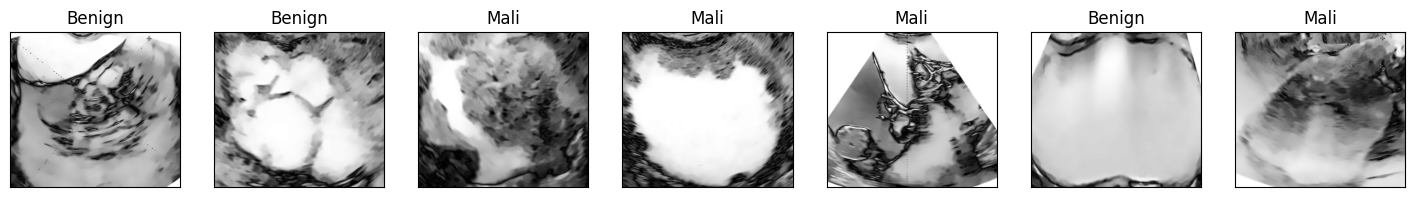

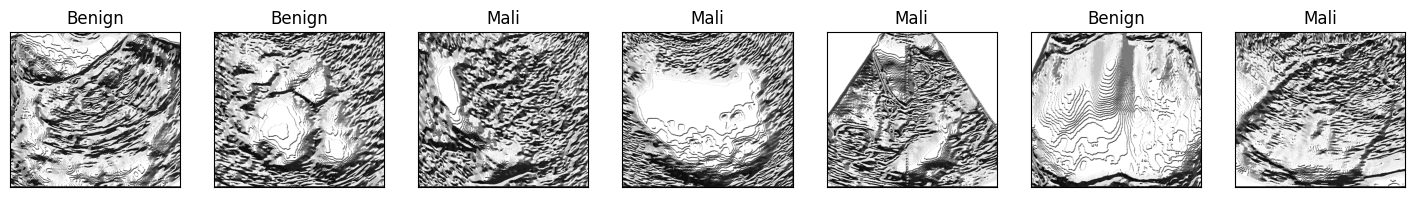

In [ ]:
show_images_with_labels(X_train, y_train, start_index=7)
show_images_with_labels(X_train_lbp, y_train, start_index=7)

Divided the image into 2x2 equalsize blocks with 256-bin histogram

In [ ]:
def create_histograms(images, sub_images_num, bins_per_sub_images):
    all_histograms = []
    for image in tqdm(images):
        grid = np.arange(0, image.shape[1]+1, image.shape[1]//sub_images_num)

        sub_image_histograms = []

        for i in range(1, len(grid)):
            for j in range(1, len(grid)):
                sub_image = image[grid[i-1]:grid[i], grid[j-1]:grid[j]]

                sub_image_histogram = np.histogram(sub_image, bins=bins_per_sub_images)[0]
                sub_image_histograms.append(sub_image_histogram)

        histogram = np.array(sub_image_histograms).flatten()
        all_histograms.append(histogram)

    return np.array(all_histograms)

In [ ]:
X_train_hist = create_histograms(X_train_lbp, sub_images_num=2, bins_per_sub_images=256)
X_test_hist = create_histograms(X_test_lbp, sub_images_num=2, bins_per_sub_images=256)

print('X_train_hist\t', X_train_hist.shape)
print('X_test_hist\t', X_test_hist.shape)

100%|██████████| 20/20 [00:00<00:00, 281.84it/s]

X_train_hist	 (80, 1024)
X_test_hist	 (20, 1024)


##d) SVM

In [ ]:
model_svm = SVC()
model_svm.fit(X_train_hist, y_train)

print('SVM train acc\t:', model_svm.score(X_train_hist, y_train))
print('SVM test acc\t:', model_svm.score(X_test_hist, y_test))

SVM train acc	: 0.65
SVM test acc	: 0.75


##e) kNN

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(X_train_hist, y_train)

print('KNN train acc\t:', model_knn.score(X_train_hist, y_train))
print('KNN test acc\t:', model_knn.score(X_test_hist, y_test))

KNN train acc	: 1.0
KNN test acc	: 0.6


##f) LR

In [ ]:
model_logreg = LogisticRegression()
model_logreg.fit(X_train_hist, y_train)

print('Logreg train acc\t:', model_logreg.score(X_train_hist, y_train))
print('Logreg test acc\t\t:', model_logreg.score(X_test_hist, y_test))

Logreg train acc	: 1.0
Logreg test acc		: 0.7


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evalutation

In [ ]:
predictions = model_knn.predict(X_test_hist)

In [ ]:
def find_misclassifications(labels, preds):
    indices = []
    for i, (label, pred) in enumerate(zip(preds, labels)):
        if pred != label:
            indices.append(i)

    return np.array(indices)

misclassifications = find_misclassifications(y_test, predictions)
misclassifications

array([ 1,  2,  3,  7,  9, 13, 14, 15])

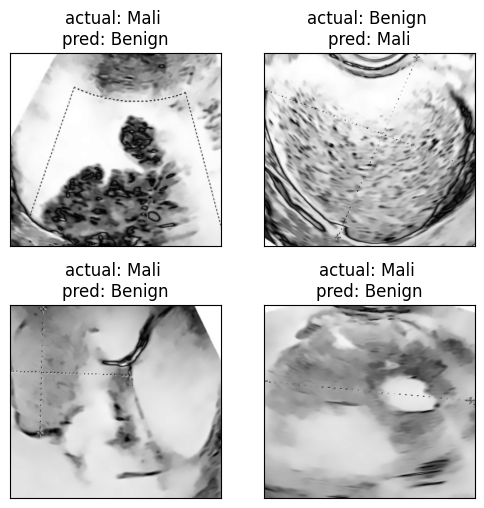

In [ ]:
def show_misclassifications(images, misclassified, labels, preds, start_index=0):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))

    index = start_index
    for i in range(2):
        for j in range(2):
            axes[i,j].imshow(images[misclassified[index]], cmap='gray')
            axes[i,j].set_title(f'actual: {classnames[labels[misclassified[index]]]} \n' \
                                f'pred: {classnames[preds[misclassified[index]]]}')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            if index == (index+2):
                break
            index += 1
    plt.show()

show_misclassifications(X_test, misclassifications, y_test, predictions, start_index=3)